### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

data=data[rowSums(data)>0,]


In [3]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [4]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [5]:
head(batches)

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa


In [6]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~Stiffness+ Stiffness:Saha)


In [7]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("background/hydrogel.soft.stiff.saha.HK.txt",header=FALSE,sep='\t')
hk_promoters=paste(hk_promoters[,1],hk_promoters[,2],hk_promoters[,3],sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))
head(hk_promoter_indices)

[1] 15 63 70 71 71 78

In [8]:
dds <- estimateSizeFactors(dds, controlGenes=hk_promoter_indices)

## Extract and store normalized counts for further analysis 

In [9]:
normcounts=counts(dds,normalized=TRUE)

#use limma's removeBatchEffect function 
#tokeep=model.matrix(~Stiffness+Stiffness:Saha,data=batches)
#normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(batches,select=c("sv1","sv2")))


write.table(normcounts,"normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [10]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,9.502967,11.842072,11.986620,15.768883,21.849202,15.3157794,16.621866,19.716969,19.586513,24.113324,15.644037,17.174173
chr1_762643_763047,1.583828,5.382760,0.000000,2.782744,5.664608,3.6037128,3.324373,4.286298,2.448314,3.288180,3.911009,6.010960
chr1_802987_803295,3.167656,7.535864,6.849497,2.782744,2.427689,0.9009282,5.318997,5.143557,7.344942,7.672421,5.214679,3.434835
chr1_804984_805589,3.167656,6.459312,1.712374,5.565488,5.664608,5.4055692,4.654122,2.571779,4.896628,5.480301,10.429358,3.434835
chr1_834765_835239,11.086795,12.918624,23.973241,13.913720,5.664608,8.1083538,3.324373,1.714519,0.000000,8.768481,6.518349,3.434835
chr1_839144_839717,20.589762,18.301384,8.561872,21.334371,12.138446,18.0185640,3.989248,3.429038,3.672471,5.480301,7.822018,9.445795


## Differential Accessibility Operation

In [11]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


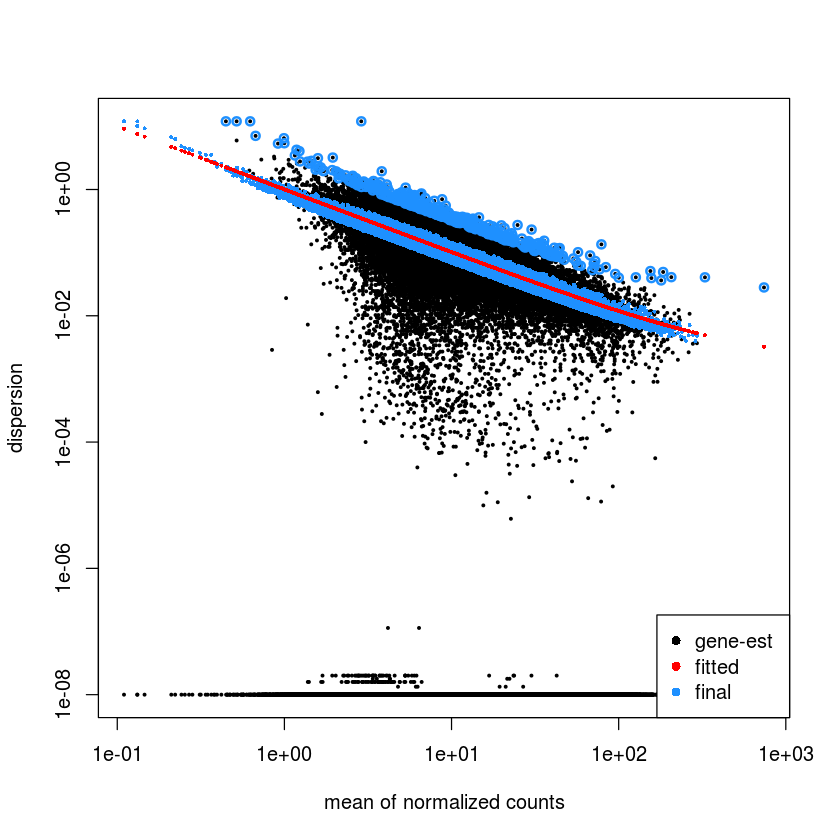

In [12]:
plotDispEsts(dds)

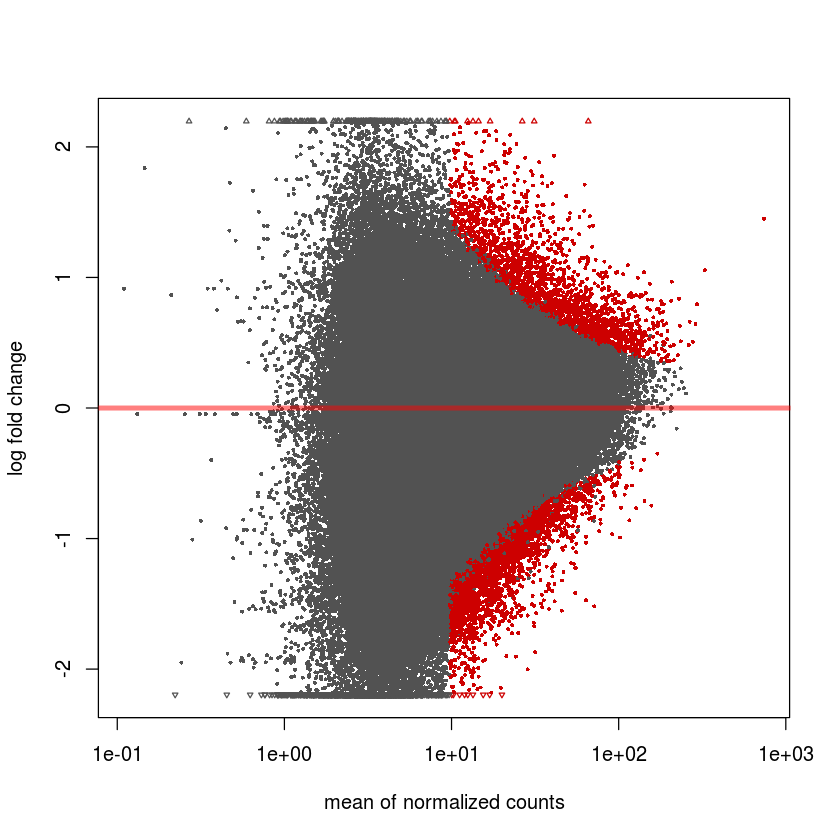

In [13]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [14]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2062, 0.93%
LFC < 0 (down)     : 2826, 1.3%
outliers [1]       : 0, 0%
low counts [2]     : 141708, 64%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1151, 0.52%
LFC < 0 (down)     : 1212, 0.55%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2305, 1%
LFC < 0 (down)     : 2789, 1.3%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [15]:

sig=res[res$padj<=0.05,]
sig=sig[order(sig$padj),]
head(sig)

log2 fold change (MLE): StiffnessStiff.SahaYes 
Wald test p-value: StiffnessStiff.SahaYes 
DataFrame with 6 rows and 7 columns
                                 baseMean    log2FoldChange             lfcSE
                                <numeric>         <numeric>         <numeric>
chr1_169443229_169443466  65.800780508858  5.17852332723067 0.576356819758295
chr1_244815880_244816787 207.826946663618 0.968654677111027 0.120690860422367
chr20_61199590_61201281  71.4328653177188 -1.52007401824153 0.195577753750521
chr1_214386199_214386921   62.58177591251  1.71142767607381 0.228545268333652
chr1_249131852_249133592 293.949400961359  0.79344658536375 0.106522480585428
chr5_154782469_154783453  62.169198171067  1.51095839165683 0.207248529302276
                                      stat               pvalue
                                 <numeric>            <numeric>
chr1_169443229_169443466    8.984925916904 2.58908663749078e-19
chr1_244815880_244816787  8.02591574640489 1.007713685456

In [16]:
write.table(sig,file="diffpeaks.tsv",row.names=TRUE,col.names=TRUE,quote=FALSE)

In [17]:
nrow(sig)

[1] 2913

## Visualizations 

In [33]:
vsd=assay(vst(dds,blind=FALSE))
rld=assay(rlog(dds,blind=FALSE))
ntd <- assay(normTransform(dds))

In [46]:
#PCA on shifted log of normalized counts
#lognc=log2(normcounts+1)
#data.pca=prcomp(t(lognc))

data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [47]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,43.19
2,8.72
3,8.31
4,6.52
5,5.90
6,5.16
7,4.72
8,4.63
9,4.46
10,4.34


In [48]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)


png 
  2

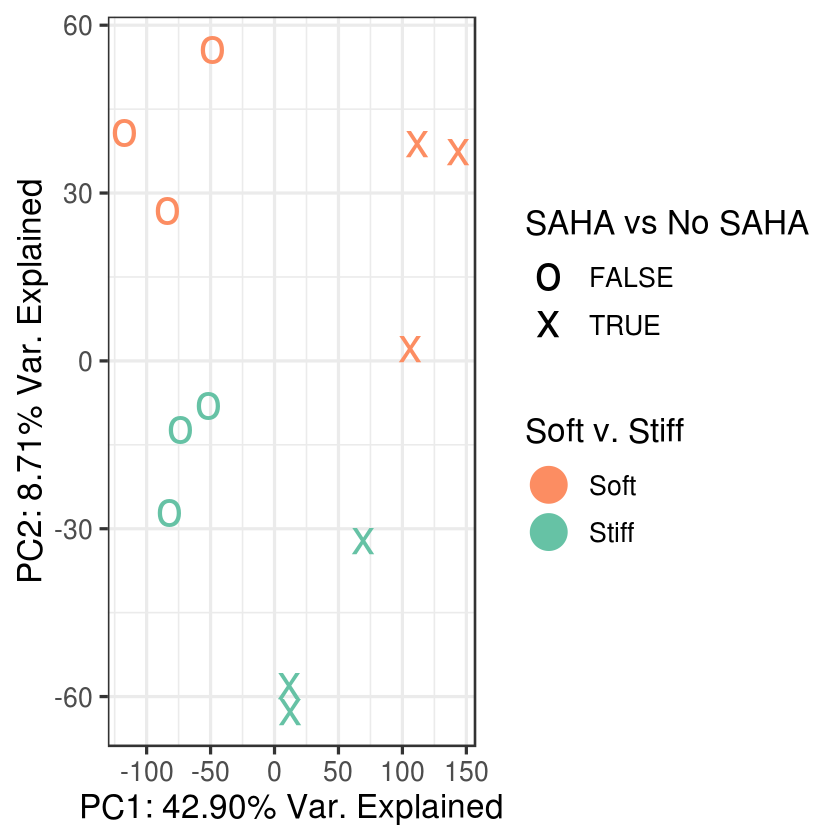

In [49]:
pca_df$Saha=c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE)
pca_df$Stiffness=c("Soft","Soft","Soft","Stiff","Stiff","Stiff","Soft","Soft","Soft","Stiff","Stiff","Stiff")
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Stiffness,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 42.90% Var. Explained")+
  ylab("PC2: 8.71% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="Soft v. Stiff")+
  scale_shape_manual(values=c("o","x"),name="SAHA vs No SAHA")
p1
svg("pca.svg",width = 8, height = 4, pointsize = 12)
print(p1)
dev.off()

In [55]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

In [58]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


### RLD

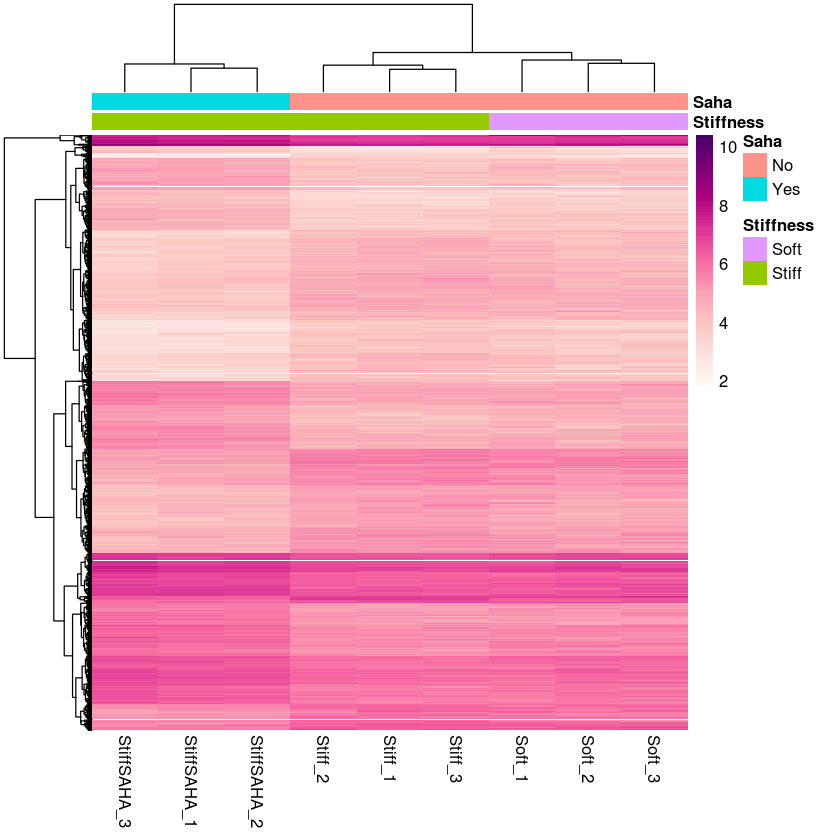

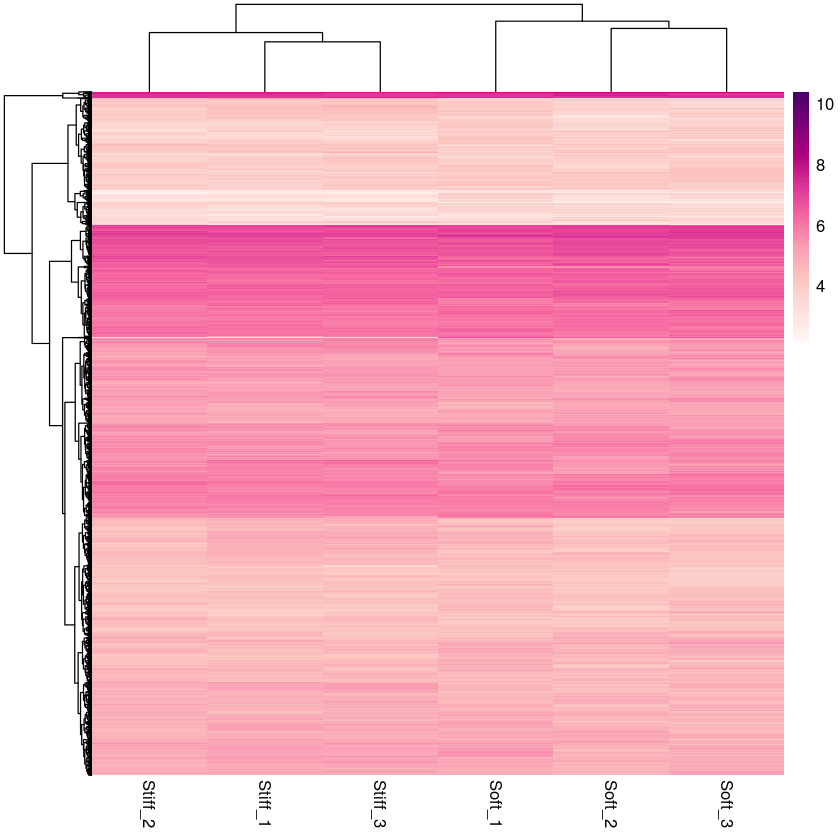

In [124]:
## Heatmap on Transformed Data 
forheatmap=rld[rownames(sig),c(1,2,3,4,5,6,10,11,12)]

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6,10,11,12),c("Stiffness","Saha")])
pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         distfun   = function(x) dist(x,method="euclidean"),
         hclustfun = function(x) hclust(x, method="ward.D"),
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
         annotation_col=df)

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6),c("Stiffness")])
forheatmap=rld[rownames(sig),c(1,2,3,4,5,6)]

pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
        )

### VST

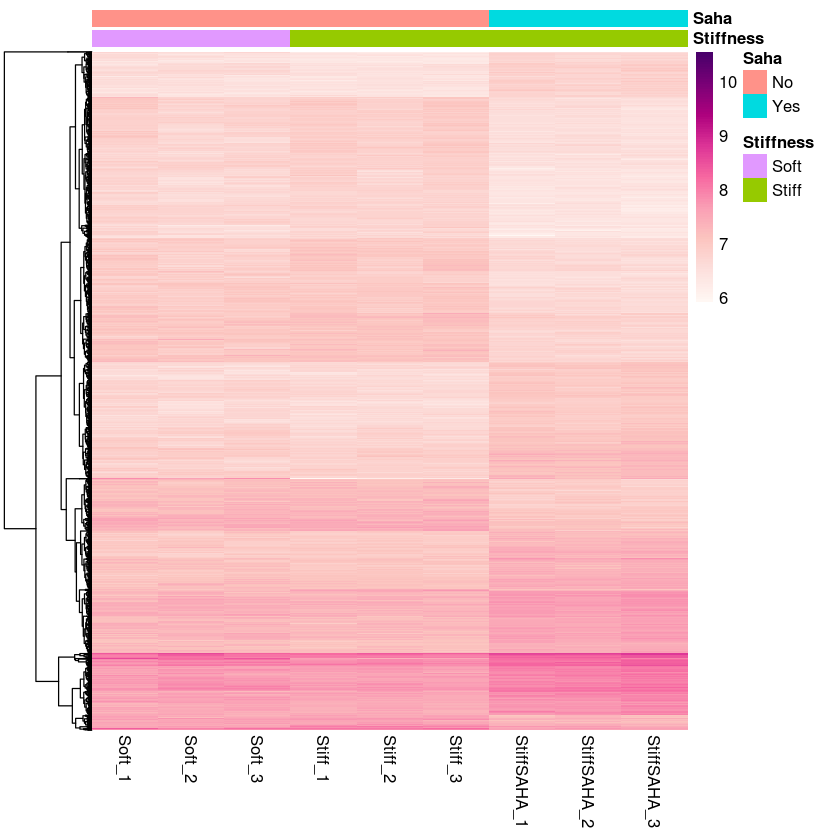

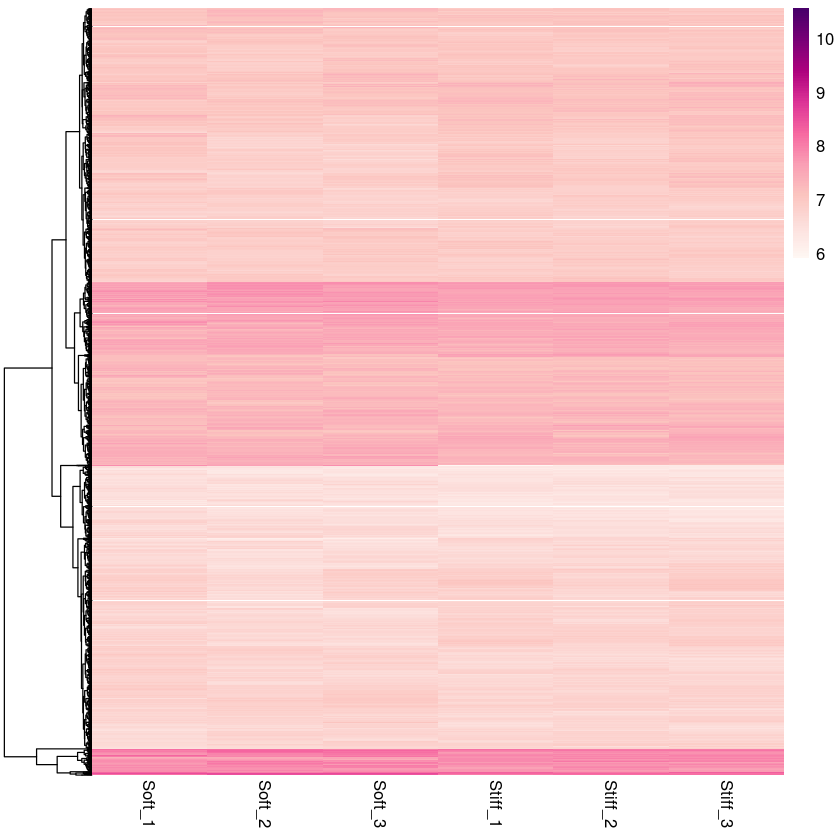

In [113]:
## vst 
## Heatmap on Transformed Data 
forheatmap=vsd[rownames(sig),c(1,2,3,4,5,6,10,11,12)]

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6,10,11,12),c("Stiffness","Saha")])
pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         distfun   = function(x) dist(x,method="euclidean"),
         hclustfun = function(x) hclust(x, method="ward.D"),
         cluster_cols=FALSE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
         annotation_col=df)

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6),c("Stiffness")])
forheatmap=vsd[rownames(sig),c(1,2,3,4,5,6)]

pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=FALSE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
        )

### LOG2(N+1)

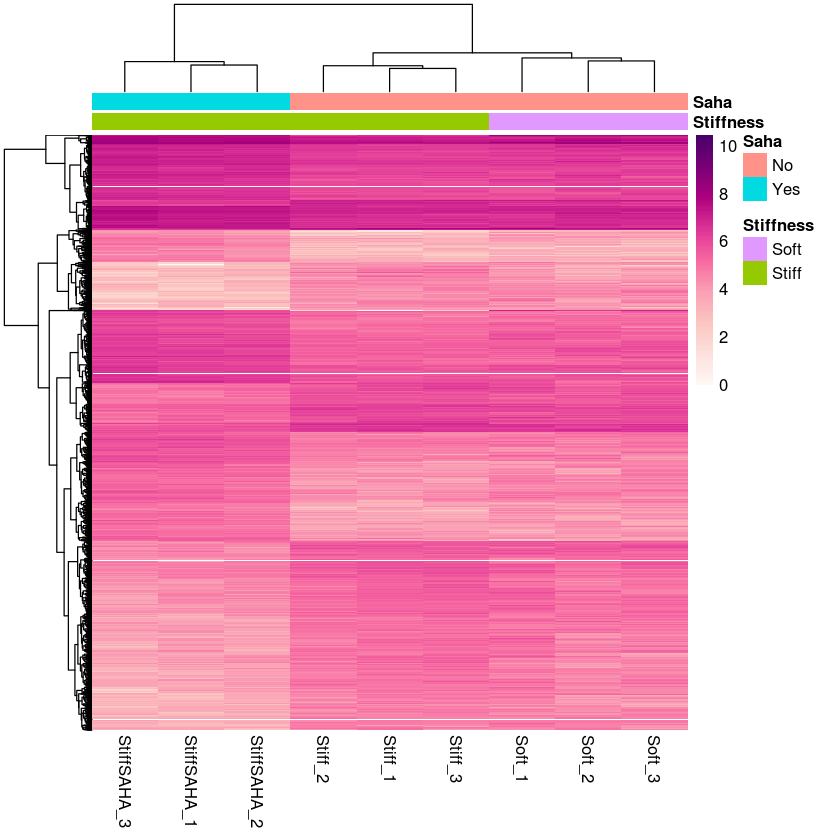

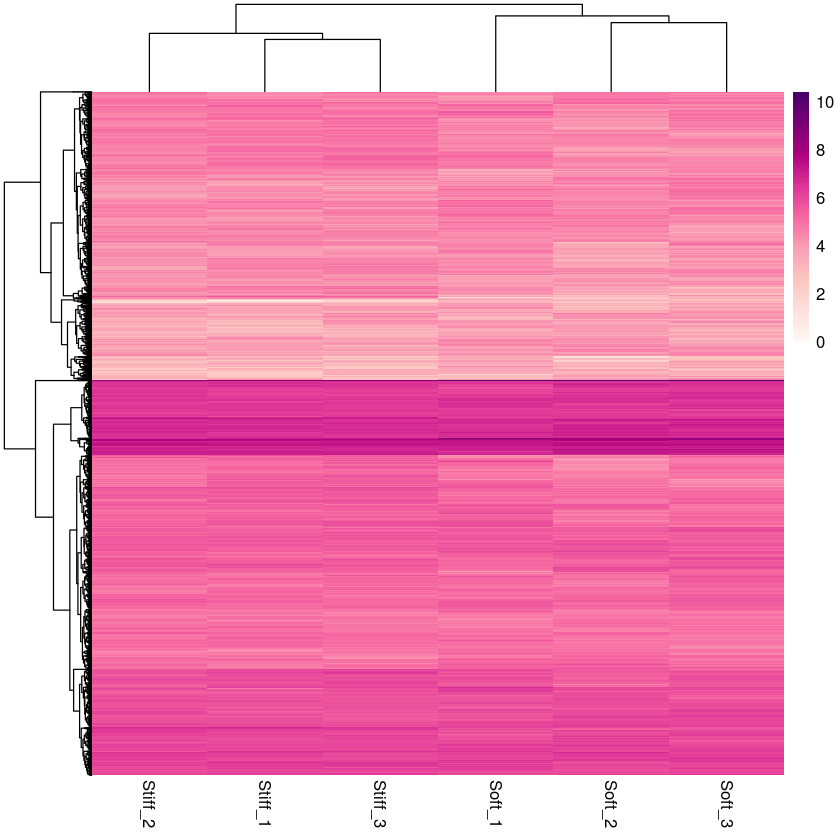

In [127]:
## log2(n+1)
## Heatmap on Transformed Data 
forheatmap=ntd[rownames(sig),c(1,2,3,4,5,6,10,11,12)]

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6,10,11,12),c("Stiffness","Saha")])
pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         distfun   = function(x) dist(x,method="euclidean"),
         hclustfun = function(x) hclust(x, method="ward.D"),
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
         annotation_col=df)

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6),c("Stiffness")])
forheatmap=ntd[rownames(sig),c(1,2,3,4,5,6)]

pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
        )

### Attempt at optimal ordering of the Z-scores 

In [130]:
forheatmap=ntd[rownames(sig),c(1,2,3,4,5,6,10,11,12)]
zscores=t(apply(forheatmap,1,scale))
zdist=dist(zscores,method='euclidean')
zdist_clustered=hclust(zdist,method="ward.D")
ordered=order.optimal(zdist,zdist_clustered$merge)
sorted=zscores[ordered$order,]

In [134]:
quantile.range <- quantile(sorted, probs = seq(0, 1, 0.01))
palette.breaks <- seq(quantile.range["5%"], quantile.range["95%"], 0.1)
colnames(sorted)=c("100Pa_Rep1","100Pa_Rep2","100Pa_Rep3","2000Pa_Rep1","2000Pa_Rep2","2000Pa_Rep3","SAHA_2000Pa_Rep1","SAHA_2000Pa_Rep2","SAHA_2000Pa_Rep3")
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(length(palette.breaks) - 1)


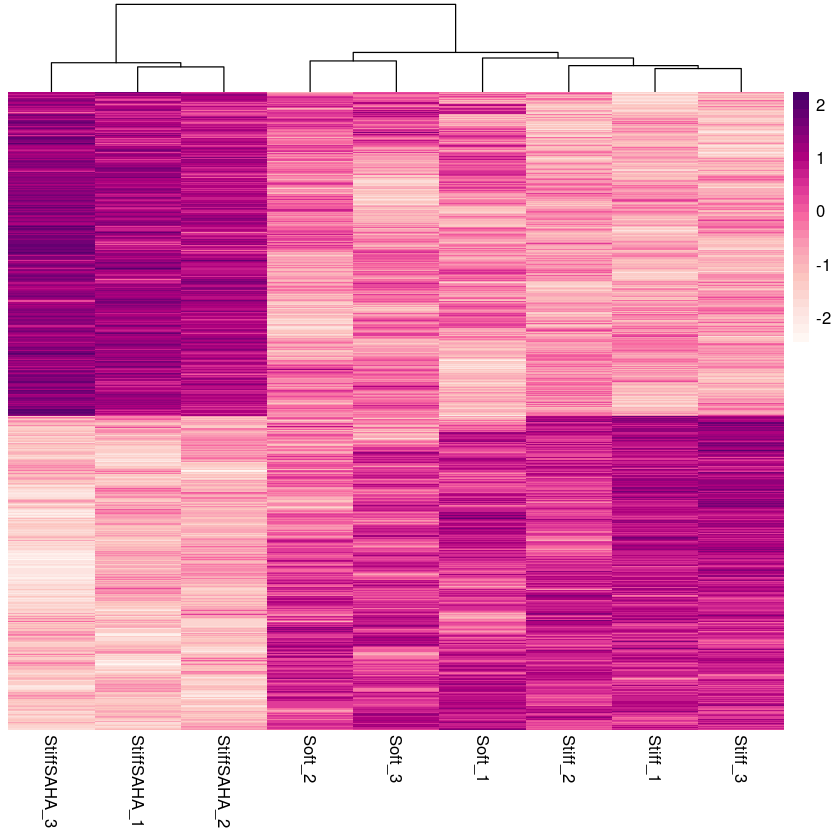

In [137]:
pheatmap(sorted,
         color=colors,
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
)


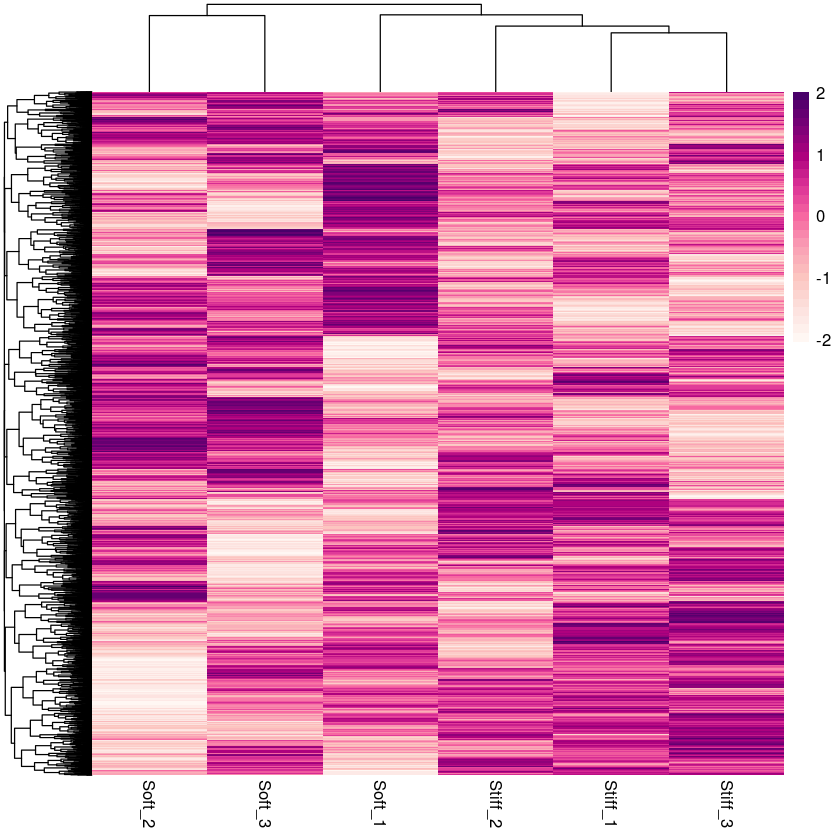

In [139]:
forheatmap=ntd[rownames(sig),c(1,2,3,4,5,6)]
zscores=t(apply(forheatmap,1,scale))
zdist=dist(zscores,method='euclidean')
zdist_clustered=hclust(zdist,method="ward.D")
ordered=order.optimal(zdist,zdist_clustered$merge)
sorted=zscores[ordered$order,]


quantile.range <- quantile(sorted, probs = seq(0, 1, 0.01))
palette.breaks <- seq(quantile.range["5%"], quantile.range["95%"], 0.1)
colnames(sorted)=c("100Pa_Rep1","100Pa_Rep2","100Pa_Rep3","2000Pa_Rep1","2000Pa_Rep2","2000Pa_Rep3")
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(length(palette.breaks) - 1)


pheatmap(sorted,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
)


## Other diff sets 

In [117]:
set1=read.table("../heatmaps/saha/all.diffpeaks.bed",header=TRUE,sep='\t')[,1]
set2=read.table("../heatmaps/saha/diffpeaks.100Pa.2000Pa.tsv",header=TRUE,sep='\t')[,1]

### Set 1 

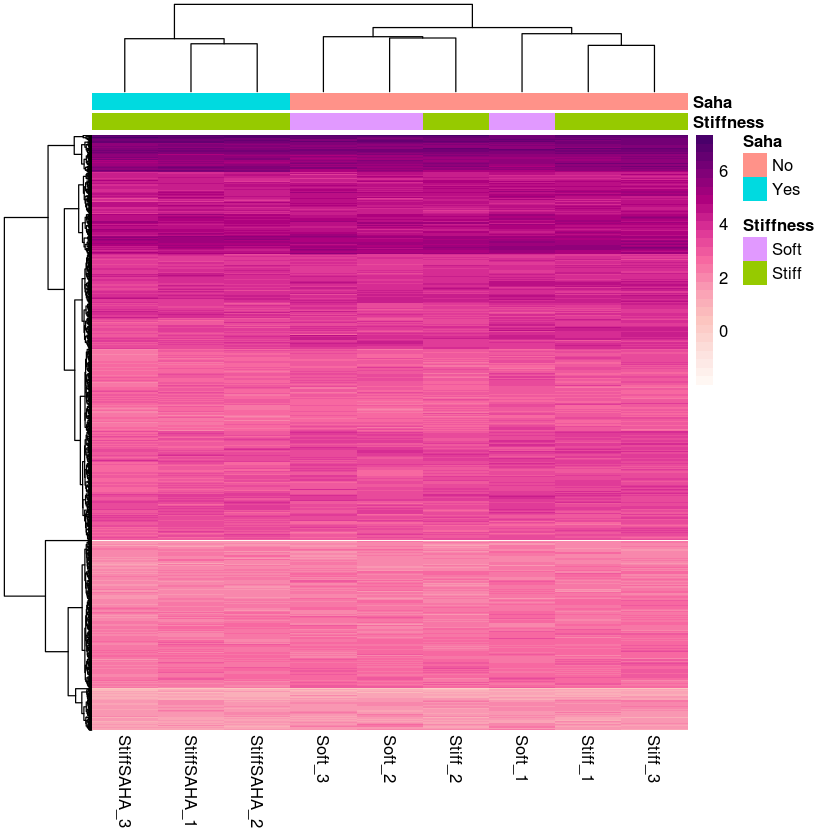

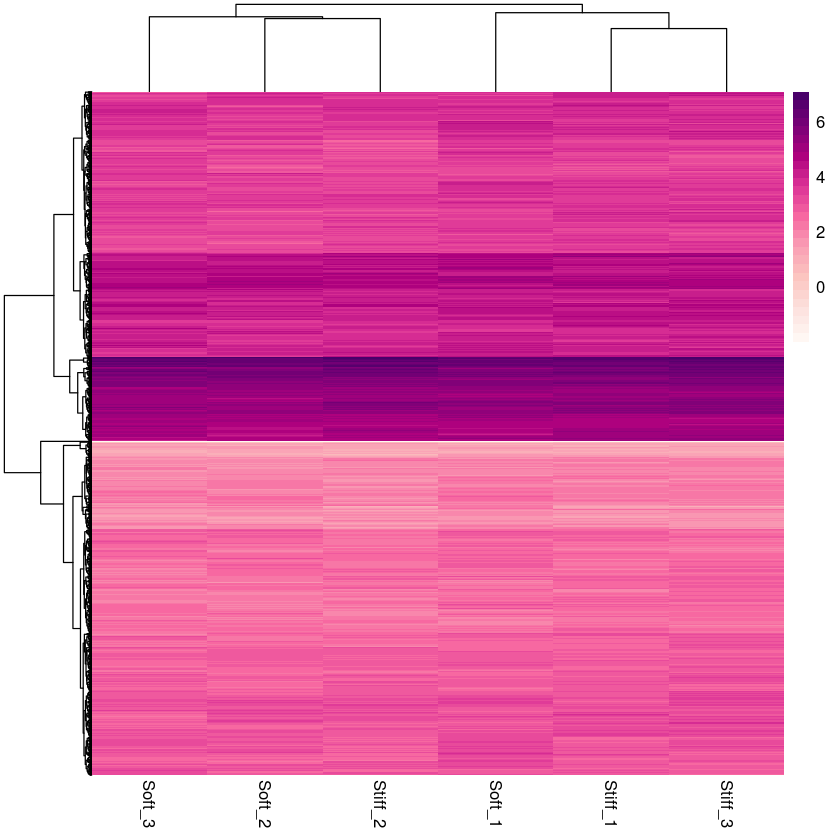

In [140]:
## Heatmap on Transformed Data 
forheatmap=rld[set1,c(1,2,3,4,5,6,10,11,12)]

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6,10,11,12),c("Stiffness","Saha")])
pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         distfun   = function(x) dist(x,method="euclidean"),
         hclustfun = function(x) hclust(x, method="ward.D"),
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
         annotation_col=df)

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6),c("Stiffness")])
forheatmap=rld[set1,c(1,2,3,4,5,6)]

pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
        )

### Set 2

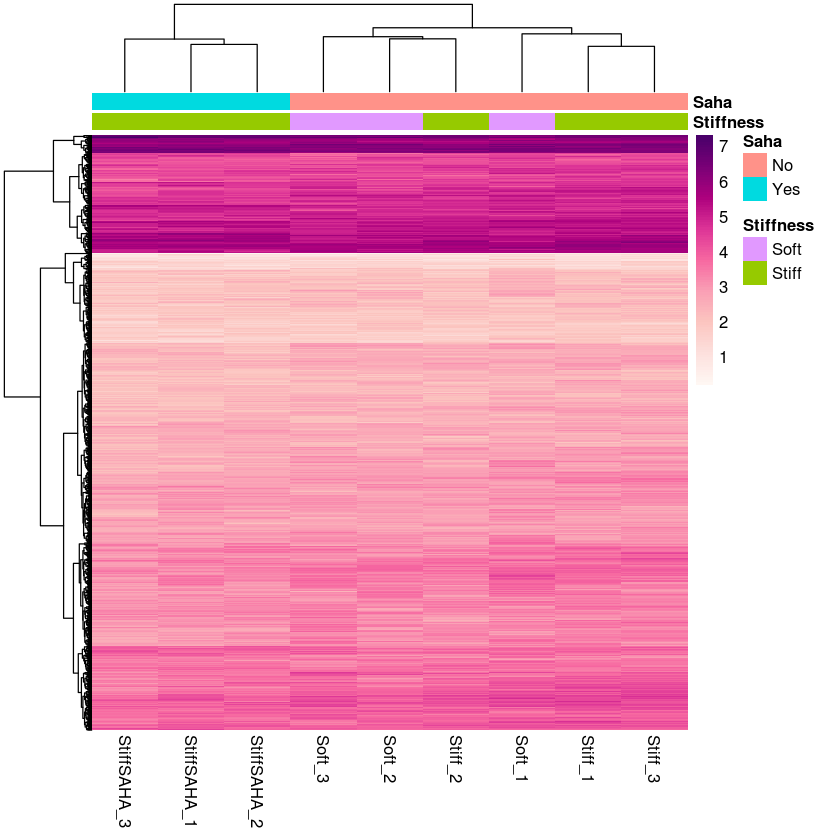

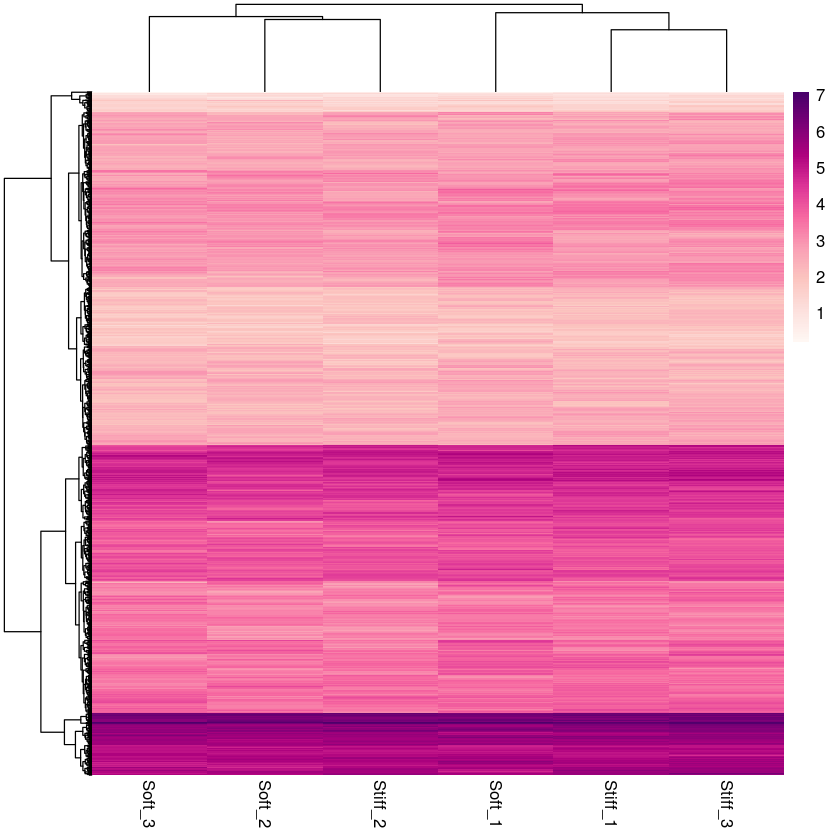

In [121]:
## Heatmap on Transformed Data 
forheatmap=rld[set2,c(1,2,3,4,5,6,10,11,12)]

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6,10,11,12),c("Stiffness","Saha")])
pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         distfun   = function(x) dist(x,method="euclidean"),
         hclustfun = function(x) hclust(x, method="ward.D"),
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3","StiffSAHA_1","StiffSAHA_2","StiffSAHA_3"),
         annotation_col=df)

df <- as.data.frame(colData(dds)[c(1,2,3,4,5,6),c("Stiffness")])
forheatmap=rld[set2,c(1,2,3,4,5,6)]

pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3")
        )